## Setup evnironment

In [764]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json
import math
import mvranalysis as mvr

## Setup plotting

In [765]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

In [766]:
switch = 20
path = '/Volumes/freeman/Nick/mVR/sessions/000100'

session = mvr.load_session(path)

In [767]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceLcts.mat
OneChoiceRcts.mat


In [769]:
#session.to_csv(path + '/behavior/session.csv')

#### Create trial summary

In [770]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [771]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep

In [772]:
if trial.trialType[0] == 1:
    mazetype = 'switchR20'
else:
    mazetype = 'switchL20'
    
print mazetype

switchR20


In [773]:
numtrls = len(trial)
boundaries = range(0, numtrls+20,20)
print boundaries

[0, 20, 40, 60, 80, 100, 120]


# Characterize Maze per trial

In [774]:
submaze = []
for b in range(numtrls):
    if mazetype == 'switchL20':
        if math.floor((b+switch)/float(switch))%2==1:
            submaze.append('L')
        else:
            submaze.append('R')
    else: #switchR20
        if math.floor((b+switch)/float(switch))%2==1:
            submaze.append('R')
        else:
            submaze.append('L')

trial['rewardSide'] = submaze

## Plot data

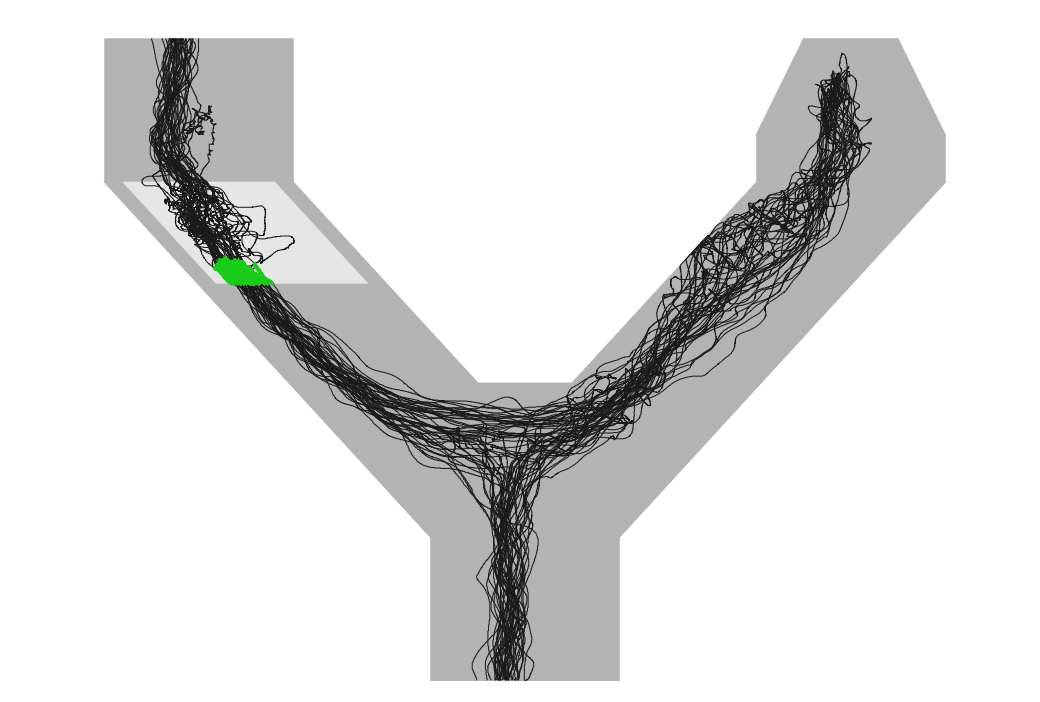

In [775]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
#print keep
mvr.draw(maze[Id],False)
mvr.trace(session, keep, [0.1, 0.1, 0.1])
mvr.licks(session, keep, [0.9, 0.1, 0.1])
mvr.water(session, keep, [0.1, 0.8, 0.1])

3
1
56


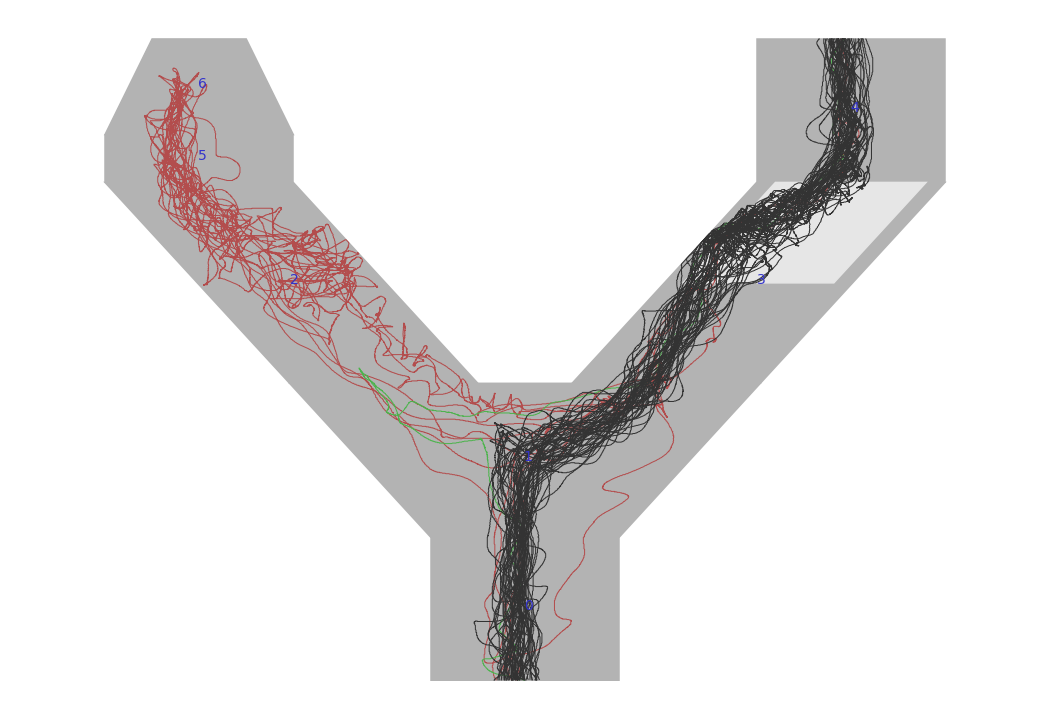

In [776]:
#For the Anti-bias Maze, Right Reward

plt.figure(figsize=[18,12])
Id = 1
mvr.draw(maze[Id],True)
branchId = 5 #dead end regardless of maze
keepE = trialEntered(branchId)



branchId = 2 #antibias right

keepW = trialEntered(branchId)


RkeepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(RkeepI)
mvr.trace(session, RkeepI, [0.7, 0.3, 0.3]) #incorrect
RkeepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(RkeepS)
mvr.trace(session, RkeepS, [0.3, 0.7, 0.3]) #entered wrong branch but corrected itself
RkeepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(RkeepC)
mvr.trace(session, RkeepC, [0.2, 0.2, 0.2]) #correct
  


16
9
20


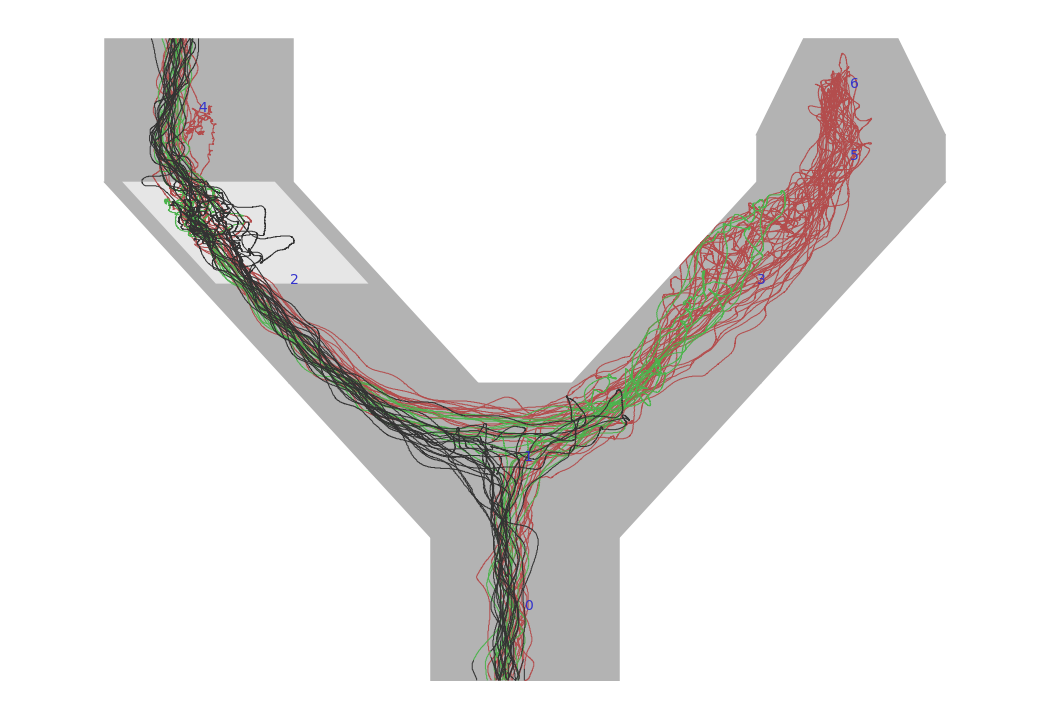

In [777]:
#For the Anti-bias maze, Left Reward
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 5 #dead end regardless of maze
keepE = trialEntered(branchId)


branchId = 3 #antibias left

keepW = trialEntered(branchId)

LkeepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(LkeepI)
mvr.trace(session, LkeepI, [0.7, 0.3, 0.3]) #incorrect
LkeepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(LkeepS)
mvr.trace(session, LkeepS, [0.3, 0.7, 0.3]) #entered wrong branch but corrected itself
LkeepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(LkeepC)
mvr.trace(session, LkeepC, [0.2, 0.2, 0.2]) #correct

In [778]:
a = LkeepI+LkeepS+LkeepC +RkeepI + RkeepS + RkeepC
a.sort()
#print LkeepC
#print a

In [780]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        #if maze[0].get('name') == "u'OneChoiceLcts.mat'":
            if x in LkeepI:
                choices[x] = "R"
            elif x in LkeepS:
                choices[x] = "RL"
            elif x in LkeepC:
                choices[x] = "L"
            elif x in RkeepI:
                choices[x] = "L"
            elif x in RkeepS:
                choices[x] = "LR"
            else:
                choices[x] = "R"
    return choices

choices = init_choice(numtrls)
print len(trial), len(choices)

trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 
#print trial

105 105


In [781]:
b = [] #Classify left and Right binary
for i in trial.initChoice:
    if i =='L':
        b.append(0)
    else:
        b.append(1)
print len(b)        

105


# Create Dot Plot

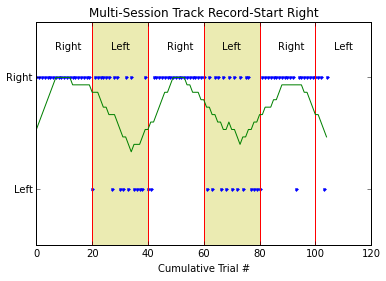

In [782]:
plt.plot(b,'.')
plt.ylim((-0.5,1.5))
plt.xlim((0,max(boundaries)))
#in which 1 = left and 0 = right
[plt.axvline(x =a, color='r') for a in boundaries]
plt.axvspan(boundaries[1],boundaries[2], facecolor = 'y', alpha = 0.3)
plt.axvspan(boundaries[3],boundaries[4], facecolor = 'y', alpha = 0.3)
#plt.axvspan(boundaries[5],boundaries[6], facecolor = 'y', alpha = 0.3)
plt.xlabel('Cumulative Trial #')

if mazetype == 'switchL20':
    plt.yticks([0,1],['Left','Right'])
    plt.title('Multi-Session Track Record-Start Left')
    plt.text(7, 1.25, 'Left')
    plt.text(27, 1.25, 'Right')
    plt.text(47, 1.25, 'Left')
    plt.text(67, 1.25, 'Right')
    plt.text(87, 1.25, 'Left')
else:
    plt.yticks([0,1],['Left','Right'])
    plt.title('Multi-Session Track Record-Start Right') 
    plt.text(7, 1.25, 'Right')
    plt.text(27, 1.25, 'Left')
    plt.text(47, 1.25, 'Right')
    plt.text(67, 1.25, 'Left')
    plt.text(87, 1.25, 'Right')
    plt.text(107, 1.25, 'Left')

avgs = []
binsize = 15
kernel = np.ones(binsize,)/float(binsize)
avgs = np.convolve(b,kernel, 'same')
plt.plot(avgs) 

In [783]:
def dead_end(numtrials):
    end = trialEntered(6)             
    return end

deadends = dead_end(numtrls)
trial['deadEnd'] = deadends
#print trial

# Create Bar Graph - overall performance

45 60
0.444444444444 0.933333333333 0.555555555556 0.0666666666667


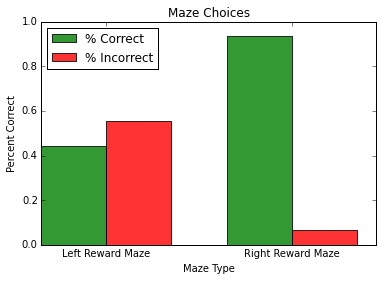

In [784]:
#Total bias split, based on initial choices

percent_correct = (len(LkeepC) +len (RkeepC))/float(numtrls)
percent_wrong = ((len(RkeepS)+len(RkeepI))+len(LkeepS)+len(LkeepI))/float(numtrls)
percent_qswitch = (len(RkeepS)+len(LkeepS))/float(numtrls)

#print percent_correct,percent_wrong, percent_qswitch

numleft = len(LkeepC+LkeepI+LkeepS)
numright = len(RkeepC+RkeepS+RkeepI)

left_corr = len(LkeepC)/float(numleft)
right_corr = len(RkeepC)/float(numright)
left_wrong = (len(LkeepS)+len(LkeepI))/float(numleft)
right_wrong = (len(RkeepS)+len(RkeepI))/float(numright)

print numleft,numright
print left_corr, right_corr, left_wrong, right_wrong

labels = ('Left Reward Maze', 'Right Reward Maze')  #Unbiased days
y_pos = np.arange(len(labels))
fig, ax = plt.subplots()

bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(y_pos, [left_corr,right_corr], bar_width,
                 alpha=opacity,
                 color='g',
                 label= '% Correct')
 
rects2 = plt.bar(y_pos + bar_width, [left_wrong,right_wrong], bar_width,
                 alpha=opacity,
                 color='r',
                 label= '% Incorrect')

plt.legend(loc='best')
plt.xticks(y_pos+bar_width, labels)
plt.xlabel('Maze Type')
plt.ylabel('Percent Correct')
plt.title('Maze Choices')
plt.show()

In [785]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
trial['Completed'] = complete

incomplete = complete.count(False)
percent_unfin = incomplete/float(len(complete))
print incomplete,percent_unfin


3 0.0285714285714


In [786]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times


In [787]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    
    for n in range(numtrials):
        start1 = session[session.number==n].time[session.curBranchId == choicept].min()
        stop1 = session[session.number==n].time[session.curBranchId == choicept].max()
        start0 = session[session.number==n].time[session.curBranchId == entrance].min()
        stop0 = session[session.number==n].time[session.curBranchId == entrance].max()
        think.append(stop1-start1)
        straight.append(stop0-start0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeChoice'] = t_choosing
trial['timeStraight'] = t_straight
#print trial

In [788]:
newfolder = path+'/summary'

In [789]:
os.mkdir(newfolder)

OSError: [Errno 17] File exists: '/Volumes/freeman/Nick/mVR/sessions/000100/summary'

In [ ]:
trial.to_csv(newfolder + '/trial_summary100.csv')